<a href="https://colab.research.google.com/github/MarcoAfB/CNN_Network_Classificando_Plantas/blob/main/Classifica%C3%A7%C3%A3o_Plantas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imghdr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, RandomFlip, RandomRotation

Com as imagens pegas da internet, iremos fazer um loop por todas elas e verificar se as librarys que iremos utilizar conseguem visualizar as imagens, caso esse não seja o caso iremos excluí-las.

In [ ]:
# Considerando apenas imagens que podem ser identificadas
data_dir = '/content/drive/MyDrive/CNN/Data/Data' 
image_exts = ['jpeg','jpg', 'bmp', 'png']
for image_class in os.listdir(data_dir): 
      for image in os.listdir(os.path.join(data_dir, image_class)):
          image_path = os.path.join(data_dir, image_class, image)
          try: 
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)
                if tip not in image_exts: 
                    os.remove(image_path)
          except Exception as e: 
                os.remove(image_path)

As imagens estão em um formato bruto, e de forma desorganizada, nessa parte iremos colocá-las em um data-set, iremos identificar as imagens (Usando o tensorflow não consegui encontrar um modo de especificar os labels, porem percebi que as imagens são nomeadas em ordem alfabética), vamos padronizar o tamanho de todos para o modelo poder identificar todas da mesma forma. Essa e outras transformações irão ser feitas.



In [ ]:
# Criando o data set
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/CNN/Data/Data',
                                                   label_mode="int",
                                                   color_mode="rgb", batch_size=32,
                                                   image_size=(256, 256),
                                                   shuffle=True)

Found 2366 files belonging to 15 classes.


Iremos normalizar o range dos pixels das imagens na matriz. Essa ferramenta de processamento é bastante eficaz, por agora seu range ser entre 1 e 0, os cálculos feitos nela demandam um poder de processamento menor. Pode também ajudar o optimizer a convergir, ou seja, encontrar os ponto em que se tem o menor erro.

In [ ]:
# Normalizando a matrix
data = data.map(lambda x,y: (x/255, y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
# O tamanho do data set, cada um terá 32 imagens e labels
len(data)

74

In [ ]:
# Criando uma variavel para que possamos acessar as imagens
data_iterator = data.as_numpy_iterator()

# E com essa função terei acesso aos dados presente em um batch
batch = data_iterator.next()

batch[0].shape

(32, 256, 256, 3)

In [ ]:
# Quantia de imagens em cada classe
for i in os.listdir(data_dir):
  a = os.listdir(os.path.join(data_dir, i))
  print(i,' ',len(a))


Suculenta Orelha de elefante   177
Suculenta diamante   183
Suculenta mãe de milhares   149
Suculenta Orelha de shrek   176
Suculenta zebra   163
Suculenta Colar de golfinhos   136
Suculenta dedo de moça   162
Suculenta Cante   142
Suculenta Colar de Botões   152
Suculenta Fantasma   170
Suculenta Tapete Persa   163
Suculenta Colar de Pérolas   193
Suculenta Orelha de Gato   148
Suculenta Lovely Rose   138
Suculenta Barba de Moisés   140


Iremos plotar as imagens que usaremos na classificação assim como o nome das plantas, elas estarão em ordem, assim, a primeira será representada também pelo número 0 como a última será a 14

Found 15 files belonging to 15 classes.


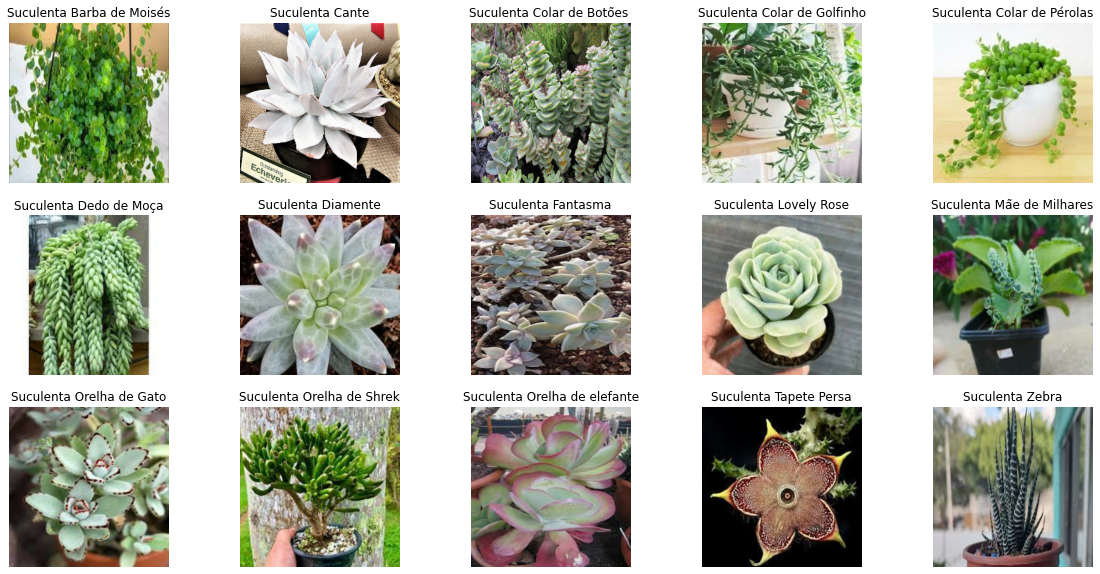

In [ ]:
# Criar um dataset com uma imagem de cada planta
exemplos = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/CNN/Data/Exemplo',
                                                   label_mode="int",
                                                   color_mode="rgb", batch_size=30,
                                                   image_size=(256, 256),
                                                   shuffle=False)
# Classe contendo o nome de cada planta
class_names = exemplos.class_names

# Iremos "chamar" o dataset para que possamos acessa-lo
exemplos = exemplos.take(1)

# As configurações da plotagem
plt.figure(figsize=(20, 10))
for images, labels in exemplos:
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype('int'))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    break

Iremos separar os dados em Treino que é onde iremos treinar e otimizar os parâmetros, validation será o set que usaremos para mensurar o quão bom está ficando os parâmetros. Em casos reais, os dois sets já são o suficiente, porem aqui iremos separar mais um chamado teste, sendo onde iremos usar como se fosse à realidade, será as imagens que iremos usar o modelo para classifica-las. E como as imagens já foram embaralhadas na criação do data set, não precisará ser feito aqui

In [ ]:
treino = data.take(int(len(data)*0.6))
validation = data.take(int(len(data)*0.2))
teste = data.take(int(len(data)*0.2))
print(f'treino irá conter {len(treino)} baches','\n'
      f'validation irá conter {len(validation)} baches','\n'
      f'teste irá conter {len(teste)} baches')

treino irá conter 44 baches 
validation irá conter 14 baches 
teste irá conter 14 baches


# CRIANDO O DEEP LEARNING


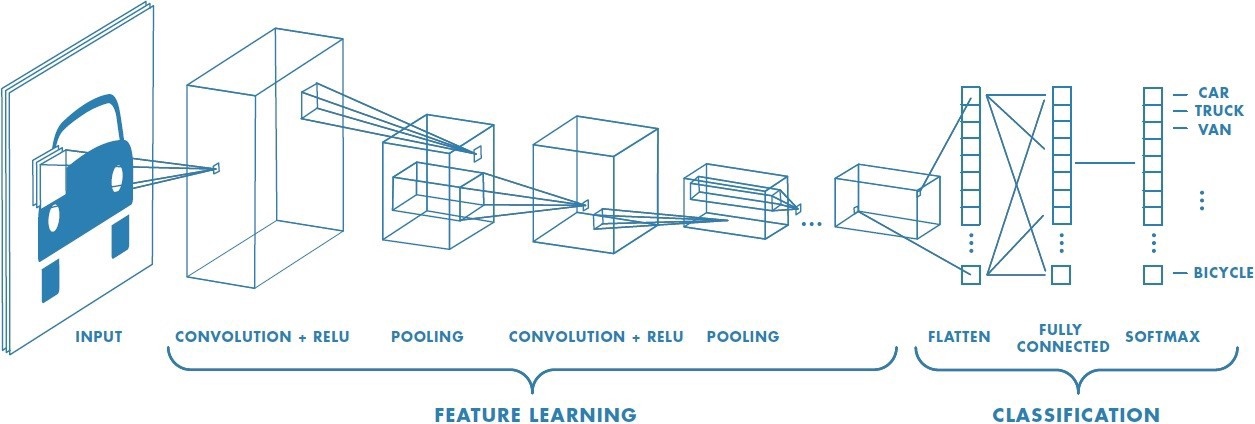



Ao criar um CNN não há "melhor" forma de montá-la antes de realmente termos os resultados, o problema é que testar várias formas diferentes é custoso, levando um bom tempo para que cada treino e teste seja concluído. Então busquei começar com CNN em que diminuiremos a complexidade da matriz que contem as imagens colocando 4 covolution layer.

Na primeira coloquei 64 covolution matriz 3x3x3 (ela está na terceira dimensão por conta do rgb), que dessa forma iremos reduzir a dimensão 256x256 para 254x254 criando 64 dessas matrizes, e teremos o maxpooling que irá coletar o maior valor em cada 2x2 da matriz 254x254 fazendo isso com as 64. Formando então 64 nova matriz com 127x127

Na segunda o processo se repete, porem serão 32 covolutional matriz ao invés de 64. Ao fim das operações da covolutional matriz e maxpooling, teremos 32 matriz 62x62

O processo se repete na terceira covolutional layer, diminuindo a matriz, e na fim da quarta temos 16 matriz, 14x14. 

O principal objetivo dos covolutional layer é formar matrizes que possam capturar padrões nas imagens, ela faz isso por meio dos covolutinal operation e depois com o maxpooling. Nesse processo serão pelo meio do treino estimado os coeficientes, quanto mais coeficientes um modelo ter mais flexível ele será, por isso, busquei reduzir o número dos mesmos no modelo, já que nosso data-set, não é grande, temos uma quantia considerada de classes, e os dados são tirados da internet, podendo haver alguns erros nas imagens (plantas de espécies diferentes, imagens que mal aparecem as plantas, etc) isso seria facilmente resolvido passando e filtrando as imagens, porem quero reduzir o máximo o contato, e subjetividade humana. 

In [ ]:
model = Sequential()

# Primeira covolutional layer
model.add(Conv2D(64, (3,3), activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

# Segunda covolutional layer
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D())

# Terceira covolutional layer
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D())

# Quarta covolutional layer
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D())

# Irá organizar os dados em uma coluna
model.add(Flatten())

# Primeira fully connected layer
model.add(Dense(120, activation='relu'))

# Output layer
model.add(Dense(15, activation='softmax'))

# Especificações de como o treino será conduzido
model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [ ]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
hist = model.fit(treino, epochs=15, validation_data=validation, callbacks=[tensorboard_callback])

Epoch 1/15
44/44 [==============================] - 25s 280ms/step - loss: 2.6838 - accuracy: 0.0831 - val_loss: 2.5225 - val_accuracy: 0.1652
Epoch 2/15
44/44 [==============================] - 15s 324ms/step - loss: 2.4874 - accuracy: 0.1790 - val_loss: 2.1975 - val_accuracy: 0.2656
Epoch 3/15
44/44 [==============================] - 13s 280ms/step - loss: 2.1606 - accuracy: 0.2770 - val_loss: 1.8865 - val_accuracy: 0.4330
Epoch 4/15
44/44 [==============================] - 13s 276ms/step - loss: 1.8716 - accuracy: 0.4276 - val_loss: 1.6723 - val_accuracy: 0.4978
Epoch 5/15
44/44 [==============================] - 13s 262ms/step - loss: 1.5226 - accuracy: 0.5455 - val_loss: 1.2355 - val_accuracy: 0.6808
Epoch 6/15
44/44 [==============================] - 15s 324ms/step - loss: 1.1334 - accuracy: 0.6626 - val_loss: 0.8321 - val_accuracy: 0.7634
Epoch 7/15
44/44 [==============================] - 14s 307ms/step - loss: 0.7713 - accuracy: 0.7770 - val_loss: 0.4793 - val_accuracy: 0.9040

In [ ]:
# Testando o modelo em imagens ainda não usadas
model.evaluate(teste, batch_size=32)

14/14 [==============================] - 4s 159ms/step - loss: 0.1011 - accuracy: 0.9866


[0.10108913481235504, 0.9866071343421936]